## BIL462 Project Source Codes | 2024-2025 Fall | Context: Iris Recognition on UBIRIS.v2 Dataset

#### Step1: IMPORT REQUIRED LIBRARIES

In [27]:
# Gerekli kütüphanelerin yüklenmesi
%pip install numpy opencv-python seaborn matplotlib pycm scikit-learn keras tensorflow visualkeras pydot graphviz

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [28]:
import os
import cv2
import numpy as np
import glob
import pickle
import random
import seaborn as sns
import time
import numpy as np
import visualkeras
import matplotlib.pyplot as plt
from pycm import ConfusionMatrix
from itertools import cycle
from PIL import ImageFont
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from collections import Counter
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Input, Conv2D, Reshape, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, ResNet152V2, VGG16, InceptionV3, InceptionResNetV2, Xception, DenseNet201
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

#### Step2: EYE & IRIS DETECTION AND ENHANCEMENT

In [29]:
# Gerekli klasörlerin oluşturulması
paths = ['paper', 'paper/closing', 'paper/iris',
         'paper/opening', 'paper/threshold', 'paper/contour',
         'final_iris2', 'edging_5']

for path in paths:
    if not os.path.exists(path):
        os.mkdir(path)

# Haar Cascade sınıflandırıcının yüklenmesi
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

In [30]:
# Görüntü işleme fonksiyonu
def transform_image(img, threshold):
    retval, threshold_img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    opening = cv2.morphologyEx(threshold_img, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(threshold_img, cv2.MORPH_CLOSE, kernel)
    open_close = cv2.bitwise_or(opening, closing, mask=None)
    return open_close, opening, closing

# Görüntülerin ve etiketlerin yüklenmesi
imgs = []
eye_detected_imgs = []
iris_eye_detected_imgs = []
currPath = os.getcwd().replace('\\', '/')

# UBIRIS.v2 veri setinin yolunu ayarlayın
dataset_path = currPath + '/CLASSES_400_300/*'

# Görüntülerin okunması ve etiketlerin çıkarılması
for filefilepath in glob.iglob(dataset_path):
    if filefilepath.endswith(".tiff"):
        img = cv2.imread(filefilepath)
        if img is None:
            continue
        imgs_colored = img.copy()

        # Görüntüyü yeniden boyutlandırma (isteğe bağlı)
        img = cv2.resize(img, (400, 300))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Dosya adından etiket çıkarma
        filename = os.path.basename(filefilepath)
        try:
            eye_id = filename.split('_')[0][1:]  # "C<ID_EYE>"
            session_id = filename.split('_')[1][1:]  # "S<ID_SESSION>"
            image_id = filename.split('_')[2].split('.')[0][1:]  # "I<ID_IMAGE>"
            label = int(eye_id)
        except:
            continue

        imgs.append([img_gray, image_id, label, imgs_colored])

print("Toplam görüntü sayısı:", len(imgs))

Toplam görüntü sayısı: 11101


In [31]:
# Göz tespiti
eyes_num = 0
for idx, (i, j, L, c) in enumerate(imgs):
    i_resized = cv2.resize(i, (400, 400))
    eyes = eye_cascade.detectMultiScale(i_resized, scaleFactor=1.1, minNeighbors=5)

    if len(eyes) >= 1:
        eye_detected_imgs.append([i, j, L, c])
        eyes_num += 1

print("Toplam göz tespit edilen görüntü sayısı:", eyes_num)

Toplam göz tespit edilen görüntü sayısı: 9974


In [ ]:
# İris tespiti
iris_num = 0
for idx, (i, j, L, c) in enumerate(eye_detected_imgs):
    # Hough Dönüşümü ile daire tespiti
    circles = cv2.HoughCircles(i, cv2.HOUGH_GRADIENT, dp=1.5, minDist=50,
                               param1=50, param2=30, minRadius=10, maxRadius=50)

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")

        max_area = 0
        best_circle = None

        for (x, y, r) in circles:
            if x - r > 0 and y - r > 0 and x + r < i.shape[1] and y + r < i.shape[0]:
                area = np.pi * (r  2)
                if area > max_area:
                    max_area = area
                    best_circle = (x, y, r)

        if best_circle is not None:
            x, y, r = best_circle
            # İris bölgesini kaydetme (isteğe bağlı)
            cv2.imwrite(f'paper/iris/{L}.{j}.jpg', c)
            iris_eye_detected_imgs.append([i, j, L, c])
            iris_num += 1

print("Toplam iris tespit edilen görüntü sayısı:", iris_num)

Toplam iris tespit edilen görüntü sayısı: 9974


In [33]:
# Görüntü işleme ve son veri setinin oluşturulması
imgs = iris_eye_detected_imgs
kernel = np.ones((5, 5), np.uint8)
random.shuffle(imgs)
test = []
final_output = []
labels = []

for idx, (i, j, L, c) in enumerate(imgs):
    gold, silver, diamond = transform_image(i, 0)
    golden_reference = np.sum(gold)

    for k in range(10, 1000, 10):
        working_img, opening, closing = transform_image(i, k)
        summing = np.sum(working_img)
        difference = summing - golden_reference

        if difference > 800:
            print("Görüntü eşiği =", k)
            print("Görüntü adı:", j)
            print(" ")

            cv2.imwrite(f'paper/threshold/{L}.{j}.jpg', working_img)
            cv2.imwrite(f'paper/opening/{L}.{j}.jpg', opening)
            cv2.imwrite(f'paper/closing/{L}.{j}.jpg', closing)

            # Kontur tespiti
            contours, _ = cv2.findContours(working_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            max_area = 0
            best_rect = None
            for z in contours:
                x, y, w, h = cv2.boundingRect(z)
                new_area = w * h

                if 20 < w < 150 and 20 < h < 150 and new_area > max_area:
                    max_area = new_area
                    best_rect = (x, y, w, h)

            if best_rect is not None:
                x, y, w, h = best_rect
                new_roi = c[y:y+h, x:x+w]
                new_roi = cv2.resize(new_roi, (150, 200))
                if new_roi.size > 0:
                    cv2.imwrite(f'final_iris2/{L}.{j}.jpg', new_roi)
            else:
                # Merkezden kırpma
                center_y = c.shape[0] // 2
                center_x = c.shape[1] // 2
                new_roi = c[center_y - 75:center_y + 75, center_x - 100:center_x + 100]
                new_roi = cv2.resize(new_roi, (200, 150))
                if new_roi.size > 0:
                    cv2.imwrite(f'final_iris2/{L}.{j}.jpg', new_roi)

            cv2.imwrite(f'paper/contour/{L}.{j}.jpg', working_img)
            cv2.imwrite(f'edging_5/{L}.{j}.jpg', i)
            test.append(i)
            final_output.append(new_roi)
            labels.append(L)
            break

print("Final output uzunluğu:", len(final_output))
print("Etiketlerin uzunluğu:", len(labels))

# Tüm görüntülerin aynı boyutta olduğundan emin olun
final_output = [np.array(img) for img in final_output if img.shape == final_output[0].shape]
final_output = np.array(final_output)
print("Final output shape:", final_output.shape)

test = np.array(test)
print("Test seti shape:", test.shape)

Görüntü eşiği = 20
Görüntü adı: 9
 
Görüntü eşiği = 20
Görüntü adı: 3
 


C:\Users\erend\AppData\Local\Temp\ipykernel_32000\744070480.py:16: RuntimeWarning: overflow encountered in scalar subtract
  difference = summing - golden_reference


Görüntü eşiği = 10
Görüntü adı: 12
 
Görüntü eşiği = 10
Görüntü adı: 5
 
Görüntü eşiği = 20
Görüntü adı: 5
 
Görüntü eşiği = 20
Görüntü adı: 6
 
Görüntü eşiği = 20
Görüntü adı: 3
 
Görüntü eşiği = 20
Görüntü adı: 7
 
Görüntü eşiği = 20
Görüntü adı: 15
 
Görüntü eşiği = 20
Görüntü adı: 6
 
Görüntü eşiği = 10
Görüntü adı: 4
 
Görüntü eşiği = 20
Görüntü adı: 4
 
Görüntü eşiği = 20
Görüntü adı: 10
 
Görüntü eşiği = 20
Görüntü adı: 2
 
Görüntü eşiği = 20
Görüntü adı: 5
 
Görüntü eşiği = 10
Görüntü adı: 2
 
Görüntü eşiği = 20
Görüntü adı: 7
 
Görüntü eşiği = 20
Görüntü adı: 1
 
Görüntü eşiği = 20
Görüntü adı: 15
 
Görüntü eşiği = 10
Görüntü adı: 5
 
Görüntü eşiği = 20
Görüntü adı: 8
 
Görüntü eşiği = 20
Görüntü adı: 3
 
Görüntü eşiği = 20
Görüntü adı: 12
 
Görüntü eşiği = 20
Görüntü adı: 8
 
Görüntü eşiği = 20
Görüntü adı: 9
 
Görüntü eşiği = 40
Görüntü adı: 9
 
Görüntü eşiği = 20
Görüntü adı: 3
 
Görüntü eşiği = 30
Görüntü adı: 4
 
Görüntü eşiği = 20
Görüntü adı: 11
 
Görüntü eşiği = 20
Gör

In [34]:
# Klasör yolları
categories = ['paper/opening', 'paper/closing', 'paper/threshold', 'paper/contour', 'paper/iris', 'edging_5', 'final_iris2']
output_folder = 'combined_images'  # Birleştirilen resimlerin kaydedileceği klasör

# Çıkış klasörü yoksa oluştur
os.makedirs(output_folder, exist_ok=True)

# Rastgele seçim işlemi için tohum belirle
np.random.seed(int(time.time()))

# İlk kategoriden 4 rastgele dosya ismi seç
reference_category = categories[0]
all_images = os.listdir(reference_category)
selected_indices = np.random.choice(len(all_images), 4, replace=False)
selected_files = [all_images[idx] for idx in selected_indices]

# Seçilen dosyaları birleştir
for category in categories:
    images_to_combine = []
    for file_name in selected_files:
        file_path = os.path.join(category, file_name)
        
        if os.path.exists(file_path):  # Dosya mevcutsa işlem yap
            img = cv2.imread(file_path)
            if img is None:
                print(f"Resim '{file_path}' yüklenemedi, atlanıyor.")
                continue

            # Çerçeve ekle
            img_with_border = cv2.copyMakeBorder(img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[255, 50, 255])
            
            # Etiket ekle
            label = os.path.basename(file_path)
            text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
            text_x = 10
            text_y = img_with_border.shape[0] - 10
            cv2.rectangle(img_with_border, (text_x, text_y - text_size[1] - 5), (text_x + text_size[0] + 5, text_y + 5), (0, 0, 0), -1)
            cv2.putText(img_with_border, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
            
            images_to_combine.append(img_with_border)
        else:
            print(f"Dosya '{file_path}' kategoride bulunamadı, atlanıyor.")
    
    if len(images_to_combine) == 4:
        # 4 resmi 2x2 grid olarak birleştir
        combined_image = np.vstack([
            np.hstack(images_to_combine[:2]),  # İlk iki resmi yatayda birleştir
            np.hstack(images_to_combine[2:])   # Son iki resmi yatayda birleştir
        ])

        # Birleştirilmiş resmi kaydet
        output_image_path = os.path.join(output_folder, f'{category.replace("/", "_")}_combined.jpg')
        cv2.imwrite(output_image_path, combined_image)
    else:
        print(f"Kategori '{category}' için yeterli resim bulunamadı. (Bulunan: {len(images_to_combine)})")

print(f"Birleştirilmiş resimler {output_folder} klasörüne kaydedildi.")


Birleştirilmiş resimler combined_images klasörüne kaydedildi.


In [35]:
# Verileri kaydetme (isteğe bağlı)
with open("test_ubiris.pickle", "wb") as f:
    pickle.dump(test, f)

with open("ubiris_features.pickle", "wb") as f:
    pickle.dump(final_output, f)

with open("ubiris_labels.pickle", "wb") as f:
    pickle.dump(labels, f)


#### Step3: CLASSIFICATION


In [36]:
# Klasifikasyon işlemi
# Verilerin ve etiketlerin yüklenmesi
imgs = []
final_output_images = []
labels = []  # labels listesini sıfırladık

for filefilepath in glob.iglob('final_iris2/*'):
    if filefilepath.endswith(".jpg"):
        img = cv2.imread(filefilepath)
        img_resized = cv2.resize(img, (400, 300))

        # Dosya adından etiket çıkarma
        filename = os.path.basename(filefilepath)
        label = int(filename.split('.')[0])
        example_number = filename.split('.')[1]

        imgs.append([img_resized, label])

print("Toplam görüntü sayısı:", len(imgs))

Toplam görüntü sayısı: 7215


In [37]:
def resize_with_padding(img, target_size):
    old_size = img.shape[:2]  # (height, width)
    ratio = min(float(target_size[0])/old_size[0], float(target_size[1])/old_size[1])
    new_size = tuple([int(x * ratio) for x in old_size])

    # Resmi yeniden boyutlandır
    img = cv2.resize(img, (new_size[1], new_size[0]))

    # Yeni boyut ile hedef boyut arasındaki farkı hesapla
    delta_w = target_size[1] - new_size[1]
    delta_h = target_size[0] - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # Görüntüyü doldur
    color = [0, 0, 0]
    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_img

# Verilerin karıştırılması ve ayrıştırılması
random.shuffle(imgs)
for i, j in imgs:
    final_output_images.append(i)
    labels.append(j)

print("Final output uzunluğu:", len(final_output_images))
print("Etiketlerin uzunluğu:", len(labels))

# Etiketlerin hazırlanması
labels_array = np.array(labels)
print("Minimum etiket değeri:", labels_array.min())
print("Maksimum etiket değeri:", labels_array.max())

# Etiketleri 0'dan başlayacak şekilde düzenleyin
labels_array = labels_array - labels_array.min()
print("Yeni minimum etiket değeri:", labels_array.min())
print("Yeni maksimum etiket değeri:", labels_array.max())

# Sınıf sayısını belirleyin
num_classes = labels_array.max() + 1
print("Toplam sınıf sayısı:", num_classes)

# Etiketleri kategorik hale getirin
y = to_categorical(labels_array, num_classes=num_classes)

# Görüntülerin hazırlanması
img_size = (224, 224)
X = np.array([resize_with_padding(img, img_size) for img in final_output_images if img is not None], dtype="float32")
print("Final output shape:", X.shape)

# Görüntülerin ön işlenmesi
X_preprocessed = preprocess_input(X)

Final output uzunluğu: 7215
Etiketlerin uzunluğu: 7215
Minimum etiket değeri: 1
Maksimum etiket değeri: 522
Yeni minimum etiket değeri: 0
Yeni maksimum etiket değeri: 521
Toplam sınıf sayısı: 522
Final output shape: (7215, 224, 224, 3)


In [ ]:
import tensorflow as tf

# Kullanılabilir GPU'ları kontrol et
print("GPU Kullanılabilir mi?:", tf.config.list_physical_devices('GPU'))

In [38]:
# Önceden eğitilmiş modelin yüklenmesi
original_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
# original_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
# original_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
# original_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
# original_model = Xception(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
# original_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
original_model.trainable = False  # Modelin ağırlıklarını donduruyoruz

# Bottleneck modelinin oluşturulması
bottleneck_input = original_model.input
bottleneck_output = original_model.output
bottleneck_model = Model(inputs=bottleneck_input, outputs=bottleneck_output)

bottleneck_model.summary()

# Özellik çıkarımı (batch processing)
batch_size = 32
bottleneck_features = []

for i in range(0, len(X_preprocessed), batch_size):
    batch = X_preprocessed[i:i + batch_size]
    batch_features = bottleneck_model.predict(batch)
    bottleneck_features.append(batch_features)

bottleneck_features = original_model.predict(X_preprocessed, batch_size=32, verbose=1)
print("Bottleneck features shape:", bottleneck_features.shape)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━

In [118]:
# Feature Works
exit()

"""
# (Opsiyonel) Mixed Precision Ayarı: Destekleyen GPU'larda eğitim hızını artırır.
try:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print("Mixed precision etkinleştirildi.")
except ImportError:
    print("Mixed precision etkin değil. Eğer GPU'nuz destekliyorsa tensorflow sürümünüzü güncelleyebilirsiniz.")

def unet_model(input_size=(224, 224, 3)):
    inputs = layers.Input(input_size)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Çıkış katmanı - float32 zorlamak için dtype ayarı
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', dtype='float32')(c9)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# img_size, X_preprocessed ve y değişkenlerinin önceden tanımlı olduğunu varsayıyoruz
img_size = (224, 224)  # Örnek
# X_preprocessed: (num_samples, 224, 224, 3)
# y: (num_samples, height, width) or benzeri

# Hedef maskeleri yeniden boyutlandır ve kanal ekle
y_resized = np.array([cv2.resize(mask, img_size) for mask in y])
y_resized = np.expand_dims(y_resized, axis=-1)

batch_size = 16
epochs = 50

# tf.data ile veri setini oluştur
dataset = tf.data.Dataset.from_tensor_slices((X_preprocessed, y_resized))
# Veriyi karıştır, batchle ve önbelleğe al
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Eğitim/Validasyon ayrımı
dataset_size = len(X_preprocessed)
val_size = int(dataset_size * 0.2)
train_size = dataset_size - val_size
train_dataset = dataset.take(train_size // batch_size)
val_dataset = dataset.skip(train_size // batch_size)

# Modeli oluşturma ve derleme
unet = unet_model(input_size=(img_size[0], img_size[1], 3))
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet.summary()

# Model eğitimi
history = unet.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset
)

# Özellik çıkarımı
bottleneck_features = unet.predict(X_preprocessed, batch_size=batch_size)
print(f"Segmentasyon Sonrası Feature Shape: {bottleneck_features.shape}")

"""


'\n# (Opsiyonel) Mixed Precision Ayarı: Destekleyen GPU\'larda eğitim hızını artırır.\ntry:\n    from tensorflow.keras.mixed_precision import experimental as mixed_precision\n    policy = mixed_precision.Policy(\'mixed_float16\')\n    mixed_precision.set_policy(policy)\n    print("Mixed precision etkinleştirildi.")\nexcept ImportError:\n    print("Mixed precision etkin değil. Eğer GPU\'nuz destekliyorsa tensorflow sürümünüzü güncelleyebilirsiniz.")\n\ndef unet_model(input_size=(224, 224, 3)):\n    inputs = layers.Input(input_size)\n    \n    # Encoder\n    c1 = layers.Conv2D(64, (3, 3), activation=\'relu\', padding=\'same\')(inputs)\n    c1 = layers.Conv2D(64, (3, 3), activation=\'relu\', padding=\'same\')(c1)\n    p1 = layers.MaxPooling2D((2, 2))(c1)\n\n    c2 = layers.Conv2D(128, (3, 3), activation=\'relu\', padding=\'same\')(p1)\n    c2 = layers.Conv2D(128, (3, 3), activation=\'relu\', padding=\'same\')(c2)\n    p2 = layers.MaxPooling2D((2, 2))(c2)\n\n    c3 = layers.Conv2D(256, (3,

In [ ]:
# Eğitim ve test setlerinin oluşturulması
X_train, X_test, y_train, y_test = train_test_split(
    bottleneck_features, y, test_size=0.2, random_state=42, stratify=y)

# Modelin oluşturulması
model = Sequential([
    Input(shape=bottleneck_features.shape[1:]),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.6),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.6),
    Dense(num_classes, activation='softmax')
])

# Modelin derlenmesi
optimizer = Adam(learning_rate=0.0001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)
model.summary()

# Erken durdurma, model kontrol noktası ve öğrenme oranı azaltma
checkpointer = ModelCheckpoint(
    filepath='ubirisv2_model.keras', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(
    monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6, verbose=1) 

# Modelin eğitilmesi
history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=200, 
                    shuffle=True,
                    validation_data=(X_test, y_test), 
                    verbose=1, 
                    callbacks=[checkpointer, early_stopping, reduce_lr])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 522)            │       134,154 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,317,642 (5.03 MB)

 Trainable params: 1,316,106 (5.02 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/200
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0034 - loss: 18.1751
Epoch 1: val_loss improved from inf to 16.35286, saving model to ubirisv2_model.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.0034 - loss: 18.1681 - val_accuracy: 0.0055 - val_loss: 16.3529 - learning_rate: 1.0000e-04
Epoch 2/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0027 - loss: 16.6583
Epoch 2: val_loss improved from 16.35286 to 15.26645, saving model to ubirisv2_model.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.0027 - loss: 16.6568 - val_accuracy: 0.0111 - val_loss: 15.2664 - learning_rate: 1.0000e-04
Epoch 3/200
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0054 - loss: 15.5035
Epoch 3: val_loss improved from 15.26645 to 14.35184, saving model to ubirisv2_model.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.0054 - loss: 15.4981 - val_accuracy: 0.0111 - val_loss: 14.3518 - learning_rate: 1.0000e-04
Epoch 4/200
180/181 ━

: 

#### Step4: EVALUATION

In [40]:
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font, to_file='ClassificationModel2D.png')

# Latex rapor için modelin özeti
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


c:\Users\erend\AppData\Local\Programs\Python\Python312\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


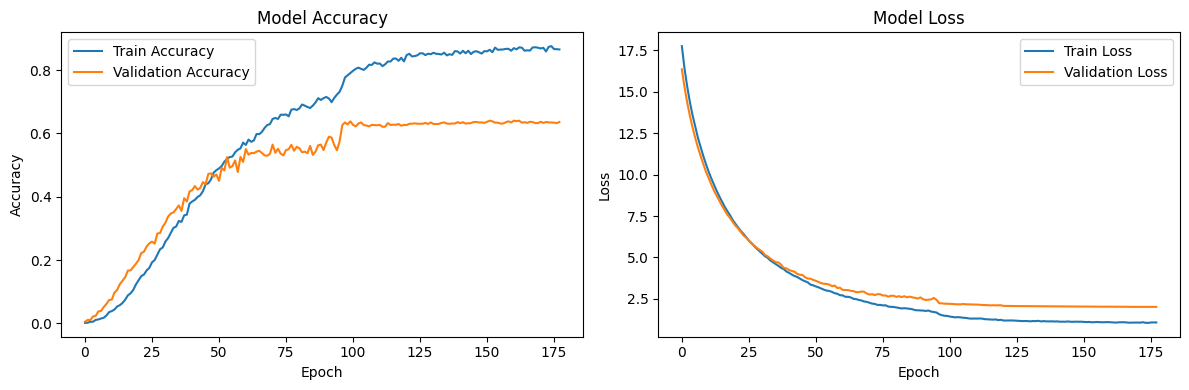

In [41]:
# Eğitim sonuçlarının görselleştirilmesi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
# Modelin değerlendirilmesi
results_test = model.predict(X_test)
y_pred = np.argmax(results_test, axis=1)
y_true = np.argmax(y_test, axis=1)

# Sınıflandırma raporu
print("Sınıflandırma Raporu:")
print(classification_report(y_true, y_pred))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.67      0.67      0.67         3
           2       0.60      1.00      0.75         3
           3       1.00      1.00      1.00         3
           4       0.50      0.33      0.40         3
           5       0.00      0.00      0.00         3
           6       0.50      0.67      0.57         3
           7       0.00      0.00      0.00         3
           8       1.00      0.67      0.80         3
           9       0.00      0.00      0.00         3
          10       1.00      1.00      1.00         3
          11       0.67      0.67      0.67         3
          12       1.00      0.67      0.80         3
          13       1.00      1.00      1.00         3
          14       1.00      0.67      0.80         3
          15       0.33      0.33      0.33         3
          16       0

c:\Users\erend\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\erend\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\erend\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

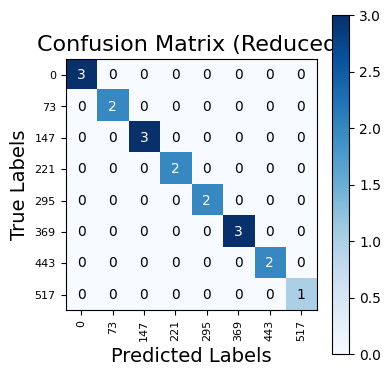

In [43]:
# Confusion Matrix oluşturma
cm = confusion_matrix(y_true, y_pred)

# Eşit aralıklarla 8 eleman seçimi (sınıf aralıklarını küçültme)
indices = np.linspace(0, cm.shape[0] - 1, 8, dtype=int)
cm_reduced = cm[indices][:, indices]

# Dinamik görsel boyutlandırma
num_classes = cm_reduced.shape[0]
figsize = (num_classes * 0.5, num_classes * 0.5)  # Her sınıf için boyutu ayarla

# Görselleştirme
plt.figure(figsize=figsize)
plt.imshow(cm_reduced, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix (Reduced)', fontsize=16)
plt.colorbar()

# X ve Y eksenine sınıfları yerleştirme
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, indices, fontsize=8, rotation=90)  # Döndürülmüş sınıf etiketleri
plt.yticks(tick_marks, indices, fontsize=8)

# Eksen etiketleri
plt.ylabel('True Labels', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=14)

# Annotasyonları ekle
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm_reduced[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_reduced[i, j] > cm_reduced.max() / 2. else "black")

# Sıkışmayı önlemek için düzenleme
plt.tight_layout()
plt.show()

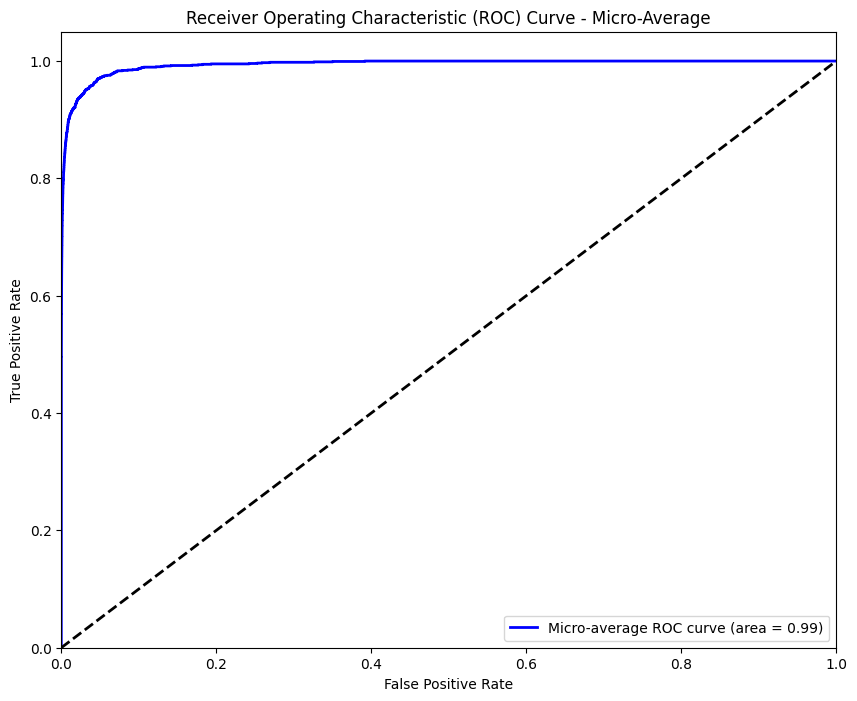

In [44]:
# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), results_test.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot micro-average ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_micro, tpr_micro, color='blue', lw=2, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_micro))

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Micro-Average')
plt.legend(loc="lower right")
plt.show()


In [74]:
results_test = model.predict(X_test)

cm = ConfusionMatrix(actual_vector=y_test.argmax(
    axis=1), predict_vector=results_test.argmax(axis=1))

# CM içerisindeki overall performans metriklerini düzenli bir tablo halinde gösterme
cm.stat()

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Overall Statistics : 

95% CI                                                            (0.61205,0.66168)
ACC Macro                                                         0.9986
ARI                                                               0.3612
AUNP                                                              0.81808
AUNU                                                              0.81776
Bangdiwala B                                                      0.49548
Bennett S                                                         0.63617
CBA                                                               0.5443
CSI                                                               None
Chi-Squared                                                       None
Chi-Squared DF                                                    267289
Conditional Entropy                                               0.79895
Cramer V                                          

c:\Users\erend\AppData\Local\Programs\Python\Python312\Lib\site-packages\pycm\cm.py:204: RuntimeWarning: Confusion matrix is high-dimensional and may not display properly. Consider using the `sparse` flag in printing functions, or save it as a CSV file for better visualization.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)



### PROJE TAM ÖZETİ ###

--- 1. VERİ SETİ BİLGİLERİ ---
Toplam Görüntü Sayısı: 7215
Göz Tespit Edilen Görüntü Sayısı: 9974
Iris Tespit Edilen Görüntü Sayısı: 9974
Sonuç Veri Seti Boyutu: (9935, 150, 200, 3)
Son Test Seti Boyutu: (9974, 300, 400)
Etiketlerin Sınıf Sayısı: 8
Etiketler (Minimum - Maksimum): 0 - 521
Son Eğitim ve Test Verisi Boyutları: (5772, 7, 7, 2048), (1443, 7, 7, 2048)

--- 2. KULLANILAN TEKNİKLER ---
1. Haar Cascade ile Göz Tespiti: Göz bölgelerinin hızlı tespiti için kullanıldı.
2. Hough Dönüşümü ile İris Segmentasyonu: İris çevresinin daire modeliyle tespiti.
3. Morfolojik İşlemler: Gürültüyü azaltmak ve net konturlar elde etmek için kullanıldı.
4. Contour Detection ile ROI Belirleme: İris bölgesindeki en iyi ROI seçildi.
5. ResNet50 Modeli: Özellik çıkarımı için pretrained ResNet50 modeli kullanıldı.
6. Bottleneck Features: Ara katmanlardan elde edilen özelliklerle sınıflandırma yapıldı.
7. Fully Connected Neural Network: Bottleneck özelliklerini sınıflandırmak i

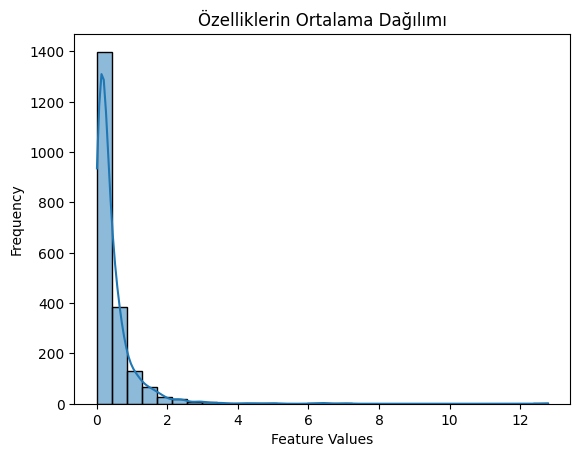

In [75]:
# Tüm proje hakkında detaylı bilgi özetini oluşturma
def generate_complete_project_summary():
    print("\n### PROJE TAM ÖZETİ ###\n")

    # 1. Veri Seti Bilgileri
    print("--- 1. VERİ SETİ BİLGİLERİ ---")
    print(f"Toplam Görüntü Sayısı: {len(imgs)}")
    print(f"Göz Tespit Edilen Görüntü Sayısı: {eyes_num}")
    print(f"Iris Tespit Edilen Görüntü Sayısı: {iris_num}")
    print(f"Sonuç Veri Seti Boyutu: {final_output.shape}")
    print(f"Son Test Seti Boyutu: {test.shape}")
    print(f"Etiketlerin Sınıf Sayısı: {num_classes}")
    print(f"Etiketler (Minimum - Maksimum): {labels_array.min()} - {labels_array.max()}")
    print(f"Son Eğitim ve Test Verisi Boyutları: {X_train.shape}, {X_test.shape}")

    # 2. Kullanılan Teknikler
    print("\n--- 2. KULLANILAN TEKNİKLER ---")
    print("1. Haar Cascade ile Göz Tespiti: Göz bölgelerinin hızlı tespiti için kullanıldı.")
    print("2. Hough Dönüşümü ile İris Segmentasyonu: İris çevresinin daire modeliyle tespiti.")
    print("3. Morfolojik İşlemler: Gürültüyü azaltmak ve net konturlar elde etmek için kullanıldı.")
    print("4. Contour Detection ile ROI Belirleme: İris bölgesindeki en iyi ROI seçildi.")
    print("5. ResNet50 Modeli: Özellik çıkarımı için pretrained ResNet50 modeli kullanıldı.")
    print("6. Bottleneck Features: Ara katmanlardan elde edilen özelliklerle sınıflandırma yapıldı.")
    print("7. Fully Connected Neural Network: Bottleneck özelliklerini sınıflandırmak için kullanıldı.")
    print("8. Confusion Matrix: Model doğruluk ve yanlışlıklarını analiz etti.")
    print("9. ROC Eğrisi ve AUC: Modelin tüm sınıflardaki performansı değerlendirildi.")
    
    # 3. Kullanılmayan Modeller
    print("\n--- 3. KULLANILMAYAN MODELLER ---")
    unused_models_details = {
        "VGG16": "Parametre sayısı çok yüksek olduğu için daha fazla bellek ve işlem gücü gerektiriyor. Ayrıca, daha yeni modeller (örneğin, ResNet50) ile karşılaştırıldığında daha düşük performans gösteriyor.",
        "InceptionV3": "Güçlü bir model olmasına rağmen, eğitim süreci uzun ve karmaşık. Proje gereksinimlerini karşılayan daha basit bir çözüm tercih edildi.",
        "InceptionResNetV2": "Inception ve ResNet mimarilerini birleştiriyor ancak hesaplama maliyeti oldukça yüksek. Veri setimiz için bu kadar derin bir ağ gereksiz görüldü.",
        "Xception": "Derinlik ayrık evrişimlere dayalı modern bir model olmasına rağmen, ResNet50'nin performansı bu proje için yeterliydi ve daha az karmaşık bir alternatif sağladı.",
        "DenseNet201": "Parametre paylaşımı ve bağlantı yoğunluğu açısından yenilikçi bir model. Ancak, daha derin yapısı nedeniyle aşırı öğrenmeye yol açma riski olduğu için tercih edilmedi."
    }

    for model, reason in unused_models_details.items():
        print(f"- {model}: {reason}")

    # 4. Model Yapısı
    print("\n--- 4. MODEL YAPISI ---")
    if hasattr(model, 'summary'):
        model.summary(print_fn=lambda x: print(x))
    else:
        print("Model summary mevcut değil. Model oluşturulmamış olabilir.")

    # 5. Eğitim Süreci
    print("\n--- 5. MODEL EĞİTİM SÜRECİ ---")
    print(f"Toplam Epoch: {len(history.history['accuracy'])}")
    print(f"Son Eğitim Doğruluğu: {history.history['accuracy'][-1]:.4f}")
    print(f"Son Eğitim Kayıp: {history.history['loss'][-1]:.4f}")
    print(f"Son Doğrulama Doğruluğu: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Son Doğrulama Kayıp: {history.history['val_loss'][-1]:.4f}")

    # 6. Özellik (Feature) Bilgileri
    print("\n--- 6. ÖZELLİK (FEATURE) BİLGİLERİ ---")
    print(f"Bottleneck Feature Boyutları: {bottleneck_features.shape}")
    print(f"Ortalama Özellik Değerleri (Genel): {np.mean(bottleneck_features):.4f}")
    print(f"Minimum Özellik Değeri: {np.min(bottleneck_features):.4f}")
    print(f"Maksimum Özellik Değeri: {np.max(bottleneck_features):.4f}")
    print(f"Standart Sapma: {np.std(bottleneck_features):.4f}")

    # Özelliklerin görselleştirilmesi
    print("\n--- 7. ÖZELLİK DAĞILIMI GÖRSELLERİ ---")
    sns.histplot(np.mean(bottleneck_features.reshape(-1, bottleneck_features.shape[-1]), axis=0), kde=True, bins=30)
    plt.title("Özelliklerin Ortalama Dağılımı")
    plt.xlabel("Feature Values")
    plt.ylabel("Frequency")
    plt.show()

# Detaylı bilgi oluştur
generate_complete_project_summary()


Seçilen örnek indeks: 881
Orijinal görüntü boyutları (Yükseklik, Genişlik, Kanal): (224, 224, 3)
Bottleneck feature map boyutları (Y, X, Kanal): (7, 7, 2048)
Toplam kanal sayısı: 2048
Gösterilecek kanal indeksleri: [1353 1187   83 1489 1346  539 1232 1499]

Normalizasyon Ayrıntıları:
Model girişi yapılmadan önce:
- Görüntü BGR formatına çevrilir.
- Her kanal için mean değer çıkarılır (B:103.939, G:116.779, R:123.68).
Bu sayede ağ, ImageNet ortalamalarına göre merkezlenen veriye bakar.


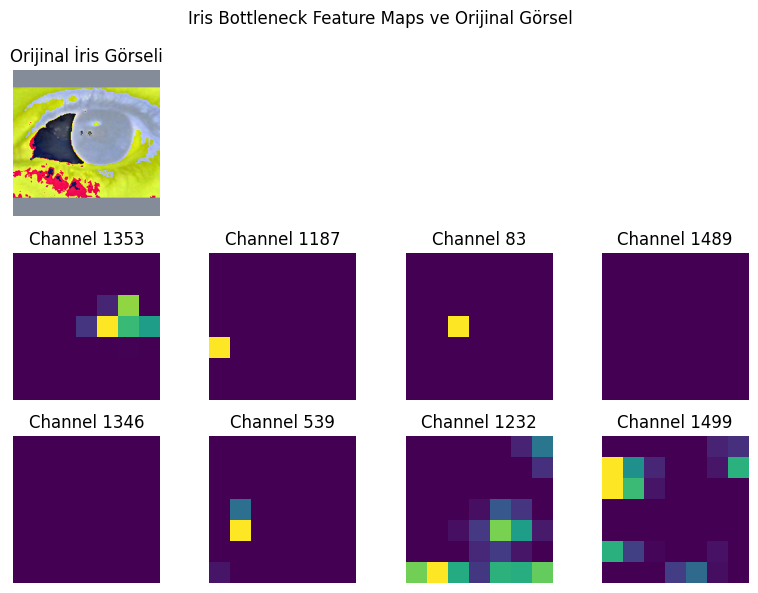


### FEATURE MAP DETAYLARI ###
Kanal 1353: min=0.0000, max=2.4188, aralık=2.4188
Kanal 1187: min=0.0000, max=0.1866, aralık=0.1866
Kanal 83: min=0.0000, max=0.1230, aralık=0.1230
Kanal 1489: min=0.0000, max=0.0000, aralık=0.0000
Kanal 1346: min=0.0000, max=0.0000, aralık=0.0000
Kanal 539: min=0.0000, max=2.3534, aralık=2.3534
Kanal 1232: min=0.0000, max=5.0049, aralık=5.0049
Kanal 1499: min=0.0000, max=5.8113, aralık=5.8113


In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Rastgele bir örnek seç
sample_index = np.random.randint(0, len(X_preprocessed))
sample_bottleneck = bottleneck_features[sample_index]

# Orijinal girdi iris resmi (normalizasyon öncesi)
original_img = X[sample_index].astype(np.uint8)

# Bilgi Çıktısı
print(f"Seçilen örnek indeks: {sample_index}")
print("Orijinal görüntü boyutları (Yükseklik, Genişlik, Kanal):", original_img.shape)
print("Bottleneck feature map boyutları (Y, X, Kanal):", sample_bottleneck.shape)

num_channels = sample_bottleneck.shape[-1]
print("Toplam kanal sayısı:", num_channels)

# Örnek olarak gösterilecek kanal sayısı
num_to_display = 8
indices = np.random.choice(num_channels, num_to_display, replace=False)
print("Gösterilecek kanal indeksleri:", indices)

# Normalizasyon detayları
# preprocess_input (ResNet50 - Caffe Modu): BGR format, mean subtraction
print("\nNormalizasyon Ayrıntıları:")
print("Model girişi yapılmadan önce:")
print("- Görüntü BGR formatına çevrilir.")
print("- Her kanal için mean değer çıkarılır (B:103.939, G:116.779, R:123.68).")
print("Bu sayede ağ, ImageNet ortalamalarına göre merkezlenen veriye bakar.")

# Görselleştirme için grid ayarları
grid_cols = 4
grid_rows = (num_to_display // grid_cols) if (num_to_display % grid_cols == 0) else (num_to_display // grid_cols + 1)

plt.figure(figsize=(grid_cols * 2, (grid_rows + 1) * 2))

# 1. satırda orijinal resmi göster
plt.subplot(grid_rows + 1, grid_cols, 1)
plt.imshow(original_img)
plt.title("Orijinal İris Görseli")
plt.axis('off')

# Feature map görselleştirmesi
feature_map_info = []
for idx, channel_idx in enumerate(indices, start=grid_cols+1):
    feature_map = sample_bottleneck[:, :, channel_idx]

    feature_map_min = feature_map.min()
    feature_map_max = feature_map.max()
    range_value = feature_map_max - feature_map_min

    # Normalizasyon: min-max aralığı [0,1]
    if range_value != 0:
        feature_map_norm = (feature_map - feature_map_min) / range_value
    else:
        feature_map_norm = feature_map  # Tüm değerler aynı ise normalizasyon gereksiz

    plt.subplot(grid_rows + 1, grid_cols, idx)
    plt.imshow(feature_map_norm, cmap='viridis')
    plt.title(f"Channel {channel_idx}")
    plt.axis('off')

    feature_map_info.append((channel_idx, feature_map_min, feature_map_max, range_value))

plt.suptitle("Iris Bottleneck Feature Maps ve Orijinal Görsel")
plt.tight_layout()
plt.show()

# Konsolda feature map bilgilerini yazdırma
print("\n### FEATURE MAP DETAYLARI ###")
for ch_idx, fmin, fmax, frange in feature_map_info:
    print(f"Kanal {ch_idx}: min={fmin:.4f}, max={fmax:.4f}, aralık={frange:.4f}")

